## Group: The Order of the PyTorch
### Milestone 1

- Members: Onur Buyukkalkan, Yi-Huai Chang, Diyanet Nijiati

- Project: Costa Rica Household Poverty Prediction

https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/overview 

In [250]:
#after initial exploration

# 0. cleaning phase
    #handle null valus
    #convert text to numeric values (edjefe, edjefa)
# 1. Create features (dependency rate, asset index, education index, ....
# 2. average household characteristics / representative(head) V
    # round target label
# 3. Generate synthetic data using Smote to balance data
    # 3.1 standardize data V
#### 4. Ensemble Modeling(to predict)not for now for the final paper

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# %pip install imblearn
from imblearn.over_sampling import SMOTE

## Step 1: Initial Exploration

In [252]:
#Load and Explore the Data
data = pd.read_csv('train.csv')
print(data.head())
print(data.describe())

             Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  ...  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  SQBhogar_nin  \
0     0  ...          100    1849               1        100             0   
1     0  ...          144    4489               1        144             0   
2     0  ...          121    8464               1          0             0   
3     0  ...           81     289              16        121             4   
4     0  ...          121    1369              16        121             4   

   SQBovercrowding  SQBdependency  SQBmeaned  agesq  Tar

In [253]:
#Checking Shape and NA Values Across Columns
print("Data shape:", data.shape)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) 
print(data.isnull().sum())

#v2a1, v18q1, rez_esc have too many null values, is this a problem?

Data shape: (9557, 143)
Id                    0
v2a1               6860
hacdor                0
rooms                 0
hacapo                0
                   ... 
SQBovercrowding       0
SQBdependency         0
SQBmeaned             5
agesq                 0
Target                0
Length: 143, dtype: int64


In [254]:
#Counts of the Target Labels
print(data['Target'].value_counts())

Target
4    5996
2    1597
3    1209
1     755
Name: count, dtype: int64


## Step 2: Plotting

We should now visualize the data

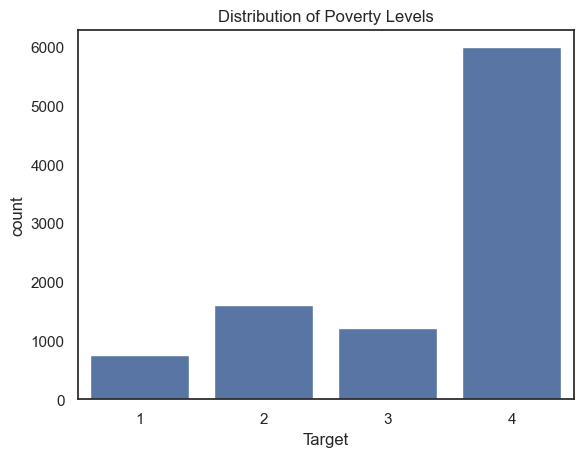

In [255]:
# Plotting the distribution of the poverty levels
sns.countplot(x='Target', data=data)
plt.title('Distribution of Poverty Levels')
plt.show()

#https://imbalanced-learn.org/stable/over_sampling.html


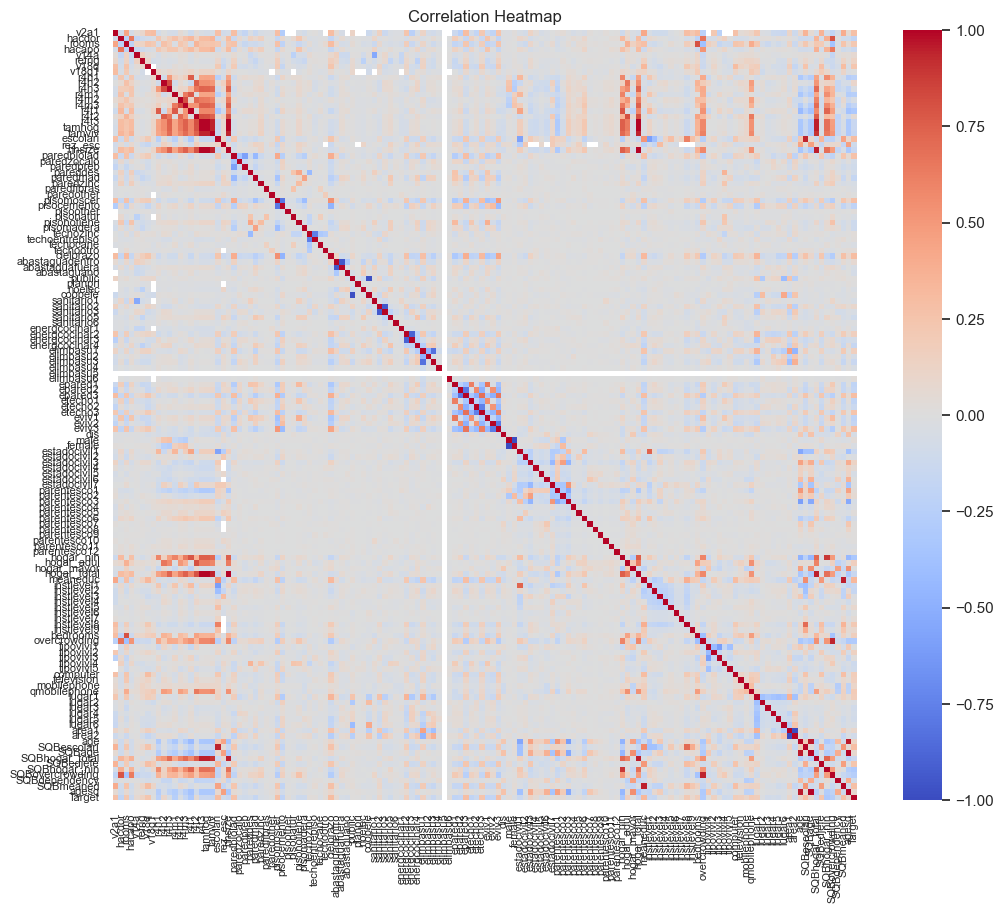

In [256]:
# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  # np.number covers integers and floats

# Now compute the correlation matrix
corr_matrix = numeric_data.corr()

# Assuming 'corr_matrix' is your correlation matrix
sns.set(style="white")  # Set style to 'white' to ensure labels are clear

plt.figure(figsize=(12, 10))  # Adjust figure size to your preference
ax = sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    cbar=True,
    xticklabels=True,
    yticklabels=True
)

# Rotate the labels on the x-axis for better visibility
plt.xticks(rotation=90, fontsize=8)  # Rotate x labels and set font size
plt.yticks(rotation=0, fontsize=8)  # Rotate y labels and set font size (if needed)

plt.title('Correlation Heatmap')
plt.show()

#We see that hhsize, tamhog, r4t3,hogar_total are the same thing by looking at the heatmap

## Step 3: Data Cleaning

We can fill n/a values with mean for consistency or maybe just drop all n/a values.

In [257]:
# Check for missing values
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending=False))

# Impute missing values with the median
for column in missing_data.index:
    if data[column].dtype != 'object':  # assuming only numeric columns need imputation
        data[column].fillna(data[column].median(), inplace=True)

# Dropping columns with more than 70% missing values
for column in missing_data.index:
    if missing_data[column] > 0.7 * len(data):
        data.drop(columns=[column], inplace=True)


rez_esc      7928
v18q1        7342
v2a1         6860
meaneduc        5
SQBmeaned       5
dtype: int64


C:\Users\onurc\AppData\Local\Temp\ipykernel_10532\253303462.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)
C:\Users\onurc\AppData\Local\Temp\ipykernel_10532\253303462.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [258]:
# Text Features to Integers
# Convert edjefe and edjefa to dummy variables
# Replace 'yes' and 'no' with 0 in 'edjefe' and 'edjefa'
data['edjefe'] = data['edjefe'].replace({'yes': 1, 'no': 0})
data['edjefa'] = data['edjefa'].replace({'yes': 1, 'no': 0})

# Convert columns to numeric
data['edjefe'] = pd.to_numeric(data['edjefe'])
data['edjefa'] = pd.to_numeric(data['edjefa'])

# Convert edjefe and edjefa to dummy variables: 1 if value > 0, otherwise 0
data['edjefe'] = (data['edjefe'] > 0).astype(int)
data['edjefa'] = (data['edjefa'] > 0).astype(int)

print(data[['edjefe', 'edjefa', 'escolari']].head())
print(data[['edjefe', 'edjefa']].dtypes)

   edjefe  edjefa  escolari
0       1       0        10
1       1       0        12
2       0       1        11
3       1       0         9
4       1       0        11
edjefe    int32
edjefa    int32
dtype: object


## Step 4: Feature Selection

The features that are available to us are described here: https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

We have a number of different features from material amenities like toilet and source of electricity to household characteristics like disability, number of kids, years in education etc. These are indirect features that might reflect the quality of life for these households.

We can use the outside wall material, roof material, number of tablets owned, toilet situation, electricity source etc. We can also create children to adult ratio, income per children, income per person in household, but we do not have income data. We can therefore find replacements that will still represent the level of income. 

#### Potential New Features 

- **Ratio of Children to Adults**: This can highlight households that may be under more financial strain.

- **Dependency Ratio**: Although it’s already provided, checking for its accurate calculation or recalculating might be useful if there are any discrepancies.

- **Asset Index**: Create a composite score based on the presence of assets (e.g., refrigerator, computer, tablet, TV) and home characteristics (types of walls, floors, and roof materials). This score can serve as a proxy for economic status.

- **Educational Level Index**: A score representing the overall educational attainment within the household.

#### Limitations

- Underreporting or overreporting to get financial assistance.
- Lack of monetary income and asset reported.
- Dimensionality problem might arise if we fail to find the most important features and eliminate the lesser important ones.

In [259]:
# Calculate new dependency rate based on hogar_nin, hogar_mayor, hogar_adul
data['adult'] = data['hogar_adul'] - data['hogar_mayor']
data['dependency_count'] = data['hogar_nin'] + data['hogar_mayor']
data['new_dependency'] = data['dependency_count'] / data['adult']
data[['hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'new_dependency', 'dependency']].head(10)

# Compare 'new_dependency', 'dependency' found that :
#   1. original dependency deal with inf(replace with 8)
#   2. original dependency no = 0, yes = 1--> just replace and use the original one
data.drop(columns=['new_dependency'], inplace=True)
data['dependency'] = data['dependency'].replace({'yes': 1, 'no': 0})
data['dependency'] = pd.to_numeric(data['dependency'])

In [260]:
#Trying Out Indexes

#Living Conditions Index
data['Living_Conditions_Index'] = (
    data[['paredblolad', 'pisomoscer', 'techozinc', 'cielorazo']].sum(axis=1) +
    data[['sanitario2', 'abastaguadentro', 'public', 'energcocinar2']].sum(axis=1) +
    data[['elimbasu1', 'sanitario2']].sum(axis=1)
)

#Economic Stability Index
data['Economic_Stability_Opportunity_Index'] = (
    data[['refrig', 'v18q', 'computer', 'television', 'mobilephone']].sum(axis=1) +
    data['meaneduc'] + (data['instlevel9'] * 2)  # Weighting postgraduate education 
)

#Social Dynamics Index
data['Social_Dynamics_Index'] = np.where(data['adult'] > 0, data['dependency_count'] / data['adult'], 0)
data.drop(columns=['adult', 'dependency_count'], inplace=True)


In [261]:
# Select only numeric columns if necessary
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

#Group by idhogar
grouped_data = data.groupby('idhogar')[numeric_cols].mean()
#Group by household before or after prediction, rounding the final label up and down for each household mean to find the target label?

# we gotta round the target to nearest integer
grouped_data['Target'] = grouped_data['Target'].round()

# Display the result
print(grouped_data.head())

           hacdor  rooms  hacapo  v14a  refrig  v18q  r4h1  r4h2  r4h3  r4m1  \
idhogar                                                                        
001ff74ca     0.0    6.0     0.0   1.0     1.0   1.0   0.0   0.0   0.0   1.0   
003123ec2     0.0    3.0     0.0   1.0     1.0   0.0   2.0   1.0   3.0   0.0   
004616164     0.0    4.0     0.0   1.0     1.0   0.0   0.0   2.0   2.0   0.0   
004983866     0.0    5.0     0.0   1.0     1.0   0.0   0.0   1.0   1.0   0.0   
005905417     0.0    8.0     0.0   1.0     0.0   0.0   1.0   1.0   2.0   0.0   

           ...  SQBedjefe  SQBhogar_nin  SQBovercrowding  SQBdependency  \
idhogar    ...                                                            
001ff74ca  ...        0.0           1.0         0.250000            1.0   
003123ec2  ...       36.0           4.0         4.000000            1.0   
004616164  ...        9.0           1.0         0.444444            1.0   
004983866  ...        0.0           1.0         1.000000        

Living_Conditions_Index                 0.317861
Economic_Stability_Opportunity_Index    0.364047
Social_Dynamics_Index                  -0.362820
Target                                  1.000000
Name: Target, dtype: float64


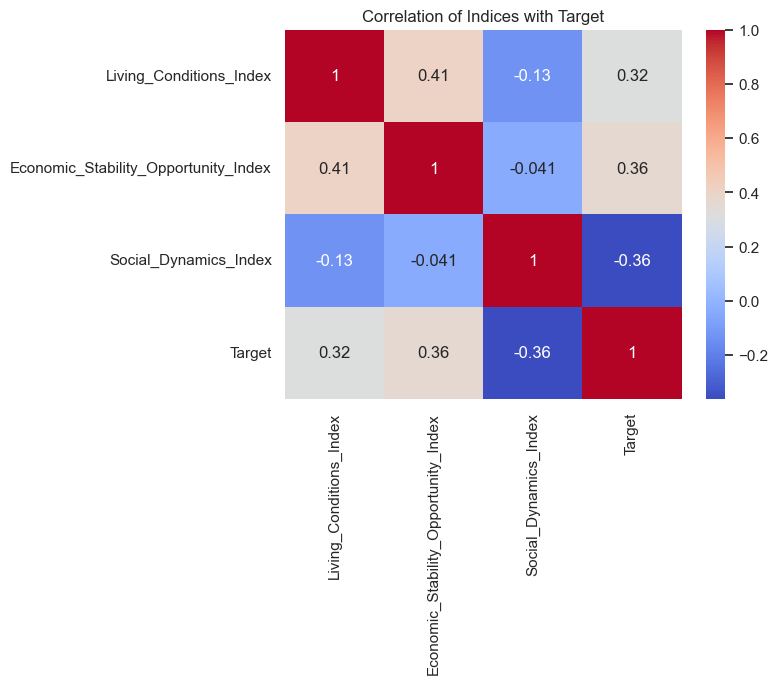

In [262]:
#Testing New Features' Correlation with Target 

correlation = data[['Living_Conditions_Index', 'Economic_Stability_Opportunity_Index', 'Social_Dynamics_Index', 'Target']].corr()
print(correlation['Target'])
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation of Indices with Target')
plt.show()

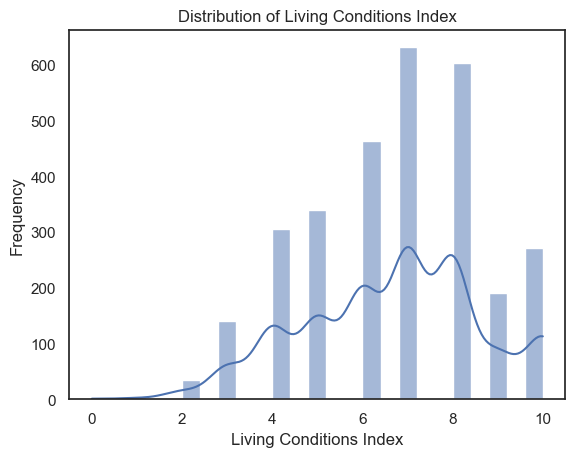

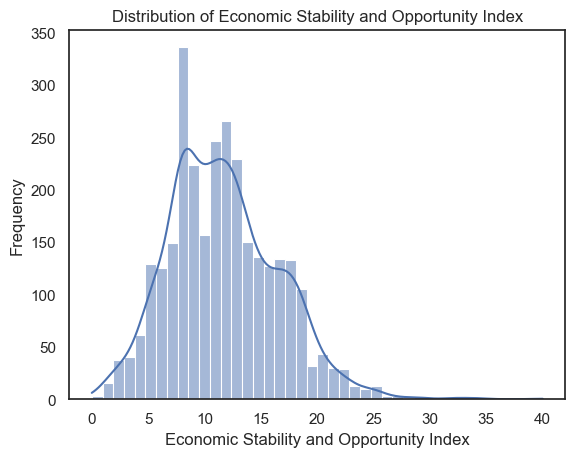

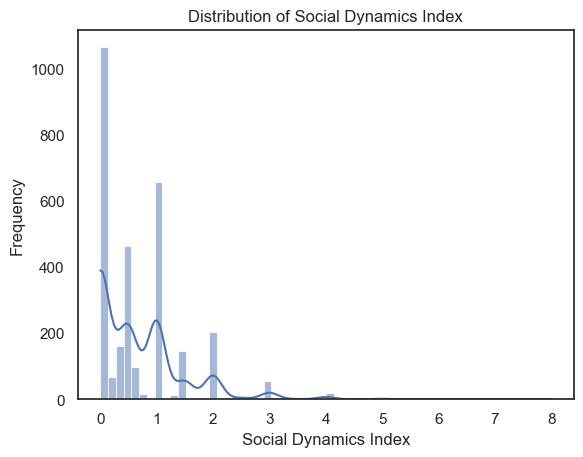

In [263]:
#Distribution of our new Features.

# Distribution of Living Conditions Index
sns.histplot(grouped_data['Living_Conditions_Index'], kde=True)
plt.title('Distribution of Living Conditions Index')
plt.xlabel('Living Conditions Index')
plt.ylabel('Frequency')
plt.show()

# Distribution of Economic Stability and Opportunity Index
sns.histplot(grouped_data['Economic_Stability_Opportunity_Index'], kde=True)
plt.title('Distribution of Economic Stability and Opportunity Index')
plt.xlabel('Economic Stability and Opportunity Index')
plt.ylabel('Frequency')
plt.show()

# Distribution of Social Dynamics Index
sns.histplot(grouped_data['Social_Dynamics_Index'], kde=True)
plt.title('Distribution of Social Dynamics Index')
plt.xlabel('Social Dynamics Index')
plt.ylabel('Frequency')
plt.show()

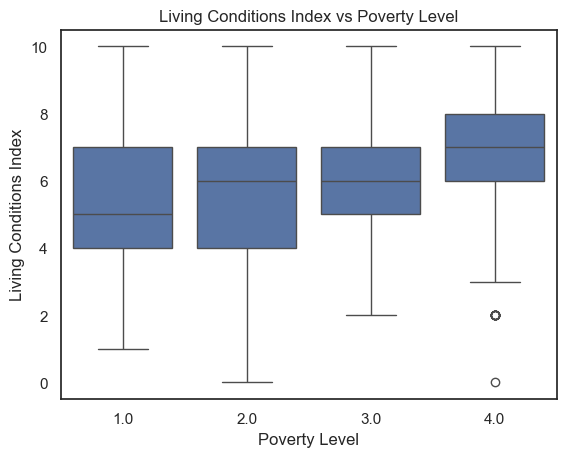

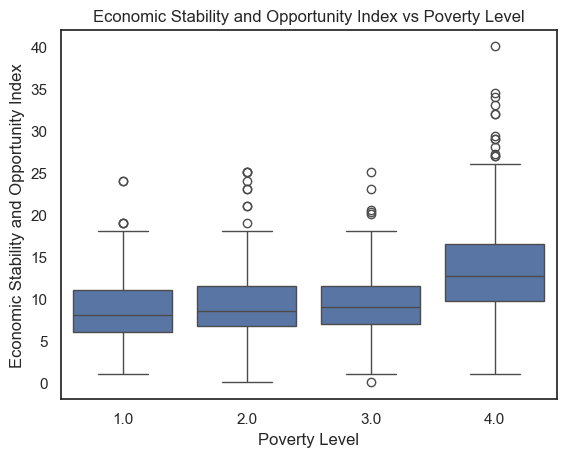

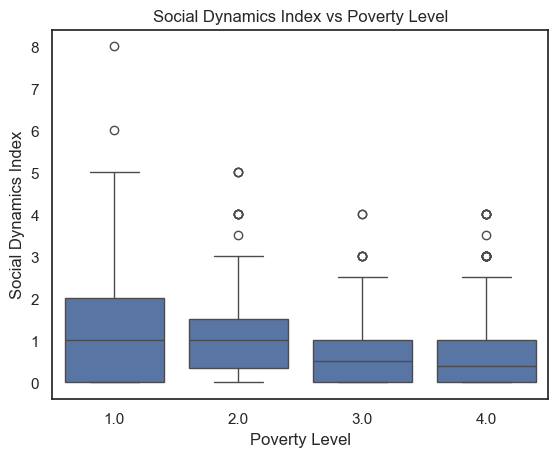

In [264]:
# Boxplot for Living Conditions Index vs Target
sns.boxplot(x='Target', y='Living_Conditions_Index', data=grouped_data)
plt.title('Living Conditions Index vs Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Living Conditions Index')
plt.show()

# Boxplot for Economic Stability and Opportunity Index vs Target
sns.boxplot(x='Target', y='Economic_Stability_Opportunity_Index', data=grouped_data)
plt.title('Economic Stability and Opportunity Index vs Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Economic Stability and Opportunity Index')
plt.show()

# Boxplot for Social Dynamics Index vs Target
sns.boxplot(x='Target', y='Social_Dynamics_Index', data=grouped_data)
plt.title('Social Dynamics Index vs Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Social Dynamics Index')
plt.show()

## Preparing the Model

We split the data, standardize it, apply smote to balance target labels.

In [265]:
# Splitting data into train, validation, and test sets
# Split the temporary set into 10% validation and 20% test set
X_train, X_temp, y_train, y_temp = train_test_split(grouped_data.drop('Target', axis=1), grouped_data['Target'], test_size=0.3, random_state=42)
# Since the temp_data is 30% of the data, we take 1/3 of it for validation (which is 10% of the total data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # 0.125 x 0.8 = 0.1

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

In [266]:
print("Training set size: ", X_train.shape)
print("After OverSampling, training set size: ", X_train_smote.shape)
print("Validation set size: ", X_val.shape)
print("Test set size: ", X_test.shape)


Training set size:  (2091, 138)
After OverSampling, training set size:  (5520, 138)
Validation set size:  (299, 138)
Test set size:  (598, 138)


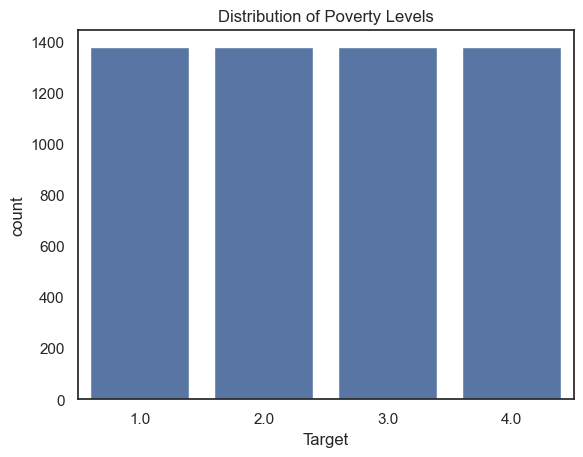

In [267]:
# Plotting the distribution of the poverty levels
sns.countplot(x=y_train_smote)
plt.title('Distribution of Poverty Levels')
plt.show()

In [268]:
#Testing Logistic Regression

# Initialize the Logistic Regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train_smote, y_train_smote)

y_val_pred = model.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         1.0       0.24      0.47      0.32        19
         2.0       0.37      0.33      0.35        52
         3.0       0.28      0.40      0.33        43
         4.0       0.84      0.71      0.77       185

    accuracy                           0.58       299
   macro avg       0.43      0.48      0.44       299
weighted avg       0.64      0.58      0.60       299



In [269]:
#Ensemble ?
# %pip install xgboost

y_train_smote = y_train_smote - 1
y_val = y_val - 1
y_test = y_test - 1

from xgboost import XGBClassifier

# Initialize the XGBClassifier with scale_pos_weight parameter
model = XGBClassifier(scale_pos_weight = sum(y_train == 0) / sum(y_train == 1))

# Fit the model
model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_val_pred = model.predict(X_val_scaled)
print(classification_report(y_val, y_val_pred))

c:\Users\onurc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.33      0.26      0.29        19
         1.0       0.46      0.31      0.37        52
         2.0       0.25      0.12      0.16        43
         3.0       0.73      0.91      0.81       185

    accuracy                           0.65       299
   macro avg       0.44      0.40      0.41       299
weighted avg       0.59      0.65      0.61       299



In [274]:
#Testing Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Fit the model on the SMOTE-augmented training data
rf_model.fit(X_train_smote, y_train_smote)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate the model using classification report
print("Classification Report for Validation Set (Random Forest):")
print(classification_report(y_val, y_val_pred_rf))

# Optionally, evaluate using accuracy score
accuracy = accuracy_score(y_val, y_val_pred_rf)
print("Accuracy of Random Forest on Validation Set:", accuracy)

Classification Report for Validation Set (Random Forest):
              precision    recall  f1-score   support

         0.0       0.19      0.16      0.17        19
         1.0       0.36      0.33      0.34        52
         2.0       0.35      0.14      0.20        43
         3.0       0.76      0.90      0.83       185

    accuracy                           0.65       299
   macro avg       0.42      0.38      0.39       299
weighted avg       0.60      0.65      0.61       299

Accuracy of Random Forest on Validation Set: 0.6454849498327759


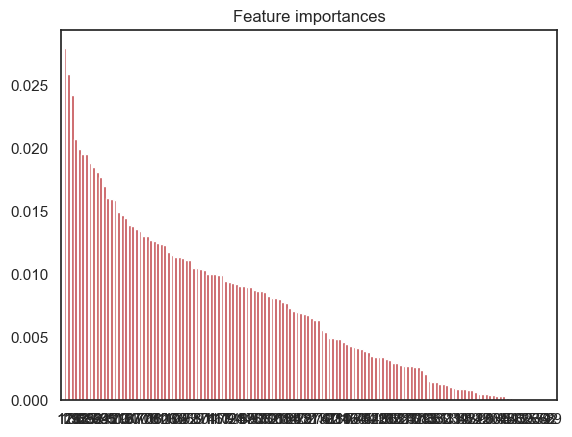

In [275]:
# Get feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_smote.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train_smote.shape[1]), indices)
plt.xlim([-1, X_train_smote.shape[1]])
plt.show()

In [276]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6, 8, 10],
    'criterion' :['gini', 'entropy']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)
best_rf_model = grid_search.best_estimator_

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)